In [56]:
import os
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics as metrics
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
class LoadData(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)

        self.x = torch.tensor(df[df.columns[1:]].values)
        self.y = torch.tensor(df['label'].values)

        self.x = self.x / 255.
        self.y = F.one_hot(self.y.to(torch.int64), num_classes=10)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [17]:
train_ds = LoadData('./mnist_2/mnist_train.csv')
test_ds = LoadData('./mnist_2/mnist_test.csv')

In [20]:
xs, ys = train_ds[0:4]

In [23]:
# Using the DataLoader class for the Dataset objects to create mini-batches of data
train_dl = DataLoader(train_ds, batch_size=5)

In [24]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break 

torch.Size([5, 784])
torch.Size([5, 10])


In [25]:
len(train_dl)

12000

In [26]:
loss = nn.CrossEntropyLoss()

In [31]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.Layer1 = nn.Linear(784, 1000)
        self.Layer2 = nn.Linear(1000, 500)
        self.Layer3 = nn.Linear(500, 100)
        self.Layer4 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.Layer1(x)
        x = self.relu(x)
        x = self.Layer2(x)
        x = self.relu(x)
        x = self.Layer3(x)
        x = self.relu(x)
        x = self.Layer4(x)
        return x.squeeze()

In [32]:
network = NN()

In [33]:
xs.shape

torch.Size([4, 784])

In [34]:
# Feeding a small sample into the network before training
network(xs)

tensor([[-0.0448, -0.0308, -0.0307,  0.0535,  0.0792,  0.0982, -0.0278, -0.0007,
          0.0159,  0.0798],
        [-0.0457, -0.0243, -0.0249,  0.0496,  0.0684,  0.0976, -0.0212, -0.0126,
          0.0167,  0.0916],
        [-0.0477, -0.0371, -0.0247,  0.0527,  0.0835,  0.1023, -0.0231,  0.0026,
          0.0169,  0.0744],
        [-0.0510, -0.0270, -0.0346,  0.0499,  0.0823,  0.1074, -0.0345, -0.0040,
          0.0173,  0.0684]], grad_fn=<SqueezeBackward0>)

In [35]:
ys

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [37]:
# Finding the loss between the current values of f(x) and y (before optimization)
loss(network(xs.float()), ys.float())

tensor(2.2957, grad_fn=<DivBackward1>)

In [42]:
def train(dl, network, epochs):
    # Defining our optimizer and loss functions
    optimizer = SGD(network.parameters(), lr=0.01)
    loss = nn.CrossEntropyLoss()

    # Training loop
    losses = []
    epoch_data = []
    for i in range(epochs):
        print(f'Epoch {i+1}/{epochs}')
        num_batches = len(dl)
        for j, (x, y) in enumerate(dl):
            # Optimizes the network using stochastic gradient descent
            optimizer.zero_grad()
            loss_val = loss(network(x).float(), y.float())
            loss_val.backward()
            optimizer.step()

            # Saving our data
            epoch_data.append(i + (j / num_batches))
            losses.append(loss_val.item())
    
    return epoch_data, losses

In [43]:
epochs, losses = train(train_dl, network=network, epochs=50)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [45]:
avg_epochs = np.asarray(epochs).reshape(50, -1).mean(axis=1)
avg_losses = np.asarray(losses).reshape(50, -1).mean(axis=1)

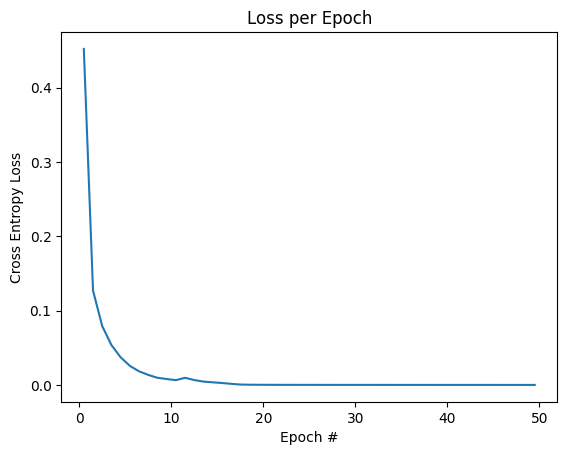

In [46]:
plt.plot(avg_epochs, avg_losses)
plt.xlabel('Epoch #')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss per Epoch')
plt.show()

In [47]:
# Testing out the model - This is what the output should look like for the first image
train_ds[0][1]

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [48]:
# This is what the output actually is
network(train_ds[0][0])

tensor([-10.4199,  -0.5651,  -5.5957,  29.3368, -28.0482,  37.1929, -16.1917,
         -9.6940,  -4.9392,   6.0861], grad_fn=<SqueezeBackward0>)

In [52]:
# To get the prediction, we take the index of the highest point of the probability density function
torch.argmax(network(train_ds[0][0]))

tensor(5)

In [55]:
# Time to test on the test set
xs, ys = test_ds[:1000]
y_hats = torch.argmax(network(xs), axis=1)

for i in range(50):
    print(f'TEST #{i} - Predicted: {y_hats[i]}. Actual: {torch.argmax(ys[i])}')

TEST #0 - Predicted: 7. Actual: 7
TEST #1 - Predicted: 2. Actual: 2
TEST #2 - Predicted: 1. Actual: 1
TEST #3 - Predicted: 0. Actual: 0
TEST #4 - Predicted: 4. Actual: 4
TEST #5 - Predicted: 1. Actual: 1
TEST #6 - Predicted: 4. Actual: 4
TEST #7 - Predicted: 9. Actual: 9
TEST #8 - Predicted: 5. Actual: 5
TEST #9 - Predicted: 9. Actual: 9
TEST #10 - Predicted: 0. Actual: 0
TEST #11 - Predicted: 6. Actual: 6
TEST #12 - Predicted: 9. Actual: 9
TEST #13 - Predicted: 0. Actual: 0
TEST #14 - Predicted: 1. Actual: 1
TEST #15 - Predicted: 5. Actual: 5
TEST #16 - Predicted: 9. Actual: 9
TEST #17 - Predicted: 7. Actual: 7
TEST #18 - Predicted: 3. Actual: 3
TEST #19 - Predicted: 4. Actual: 4
TEST #20 - Predicted: 9. Actual: 9
TEST #21 - Predicted: 6. Actual: 6
TEST #22 - Predicted: 6. Actual: 6
TEST #23 - Predicted: 5. Actual: 5
TEST #24 - Predicted: 4. Actual: 4
TEST #25 - Predicted: 0. Actual: 0
TEST #26 - Predicted: 7. Actual: 7
TEST #27 - Predicted: 4. Actual: 4
TEST #28 - Predicted: 0. Actua

In [60]:
# Final test accuracy
ys = torch.argmax(ys, axis=1)

test_acc = metrics.Accuracy(task='multiclass', num_classes=10)
test_acc(y_hats, ys)

tensor(0.9820)